In [140]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [141]:
data = pd.read_csv('Preprocessed2.csv')

In [142]:
#csv doesnt have categories as categories so make sure
cat_cols = ['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'MaritalStatus', 'DayOfWeekClaimed', 
                       'MonthClaimed', 'WeekOfMonthClaimed','PolicyType', 'VehicleCategory', 'VehiclePrice', 
                      'RepNumber', 'DriverRating', 'Days:Policy-Accident', 'Days:Policy-Claim', 
                      'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 
                      'AddressChange-Claim', 'NumberOfCars', 'Year']
for col in cat_cols:
    data[col] = data[col].astype('category')

# K- Fold Cross Val

In [143]:
X = data.iloc[:,:-1]
y = data['label'].array
gnb = GaussianNB()
tree = DecisionTreeClassifier(random_state=39)
knn = KNeighborsClassifier(n_neighbors=3)
log = LogisticRegression(solver='lbfgs', max_iter=10000)
rf = RandomForestClassifier(max_depth=2, random_state=39)
cv = StratifiedKFold(n_splits=10, random_state=39, shuffle=True)
models = [gnb, tree, knn, log, rf]

In [144]:
for model in models:
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
    print('Mean Accuracy of {}: %.3f (%.3f)'.format(str(model)) % (np.mean(scores), np.std(scores))) 
    print('Min and Max Accuracy of {}: %.3f (%.3f)'.format(str(model)) % (scores.min(), scores.max()))

Mean Accuracy of GaussianNB(): 0.825 (0.016)
Min and Max Accuracy of GaussianNB(): 0.797 (0.849)
Mean Accuracy of DecisionTreeClassifier(random_state=39): 0.896 (0.008)
Min and Max Accuracy of DecisionTreeClassifier(random_state=39): 0.883 (0.908)
Mean Accuracy of KNeighborsClassifier(n_neighbors=3): 0.932 (0.003)
Min and Max Accuracy of KNeighborsClassifier(n_neighbors=3): 0.926 (0.936)
Mean Accuracy of LogisticRegression(max_iter=10000): 0.940 (0.000)
Min and Max Accuracy of LogisticRegression(max_iter=10000): 0.940 (0.940)
Mean Accuracy of RandomForestClassifier(max_depth=2, random_state=39): 0.940 (0.000)
Min and Max Accuracy of RandomForestClassifier(max_depth=2, random_state=39): 0.940 (0.940)


# Train/test split

In [145]:
#split into stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state=39, stratify = y)
train, test = train_test_split(data, test_size=0.34, random_state=39, stratify = data['label'])
print(len(train[train['label'] == 1]) / len(train))
print(len(test[test['label'] == 1]) / len(test))

0.059846698113207544
0.059889376311272176


# Helper Functions

In [146]:
def mcc(Tp, Tn, Fp, Fn):
    top = (Tp * Tn) - (Fp * Fn)
    bot = (Tp + Fp) * (Tp + Fn) * (Tn + Fp) * (Tn + Fn)
    botS = bot**0.5
    return (top / botS)

In [147]:
def metrics(model, test, title, title2): 
    y_pred = model.predict(test)
    cf = confusion_matrix(y_test, y_pred)
    n = len(y_test)
    n0 = (np.count_nonzero(y_test == 0))
    n1 = (np.count_nonzero(y_test == 1))
    w0 = n0/n
    w1 = n1/n
    n = cf.sum().sum()
    tn = cf[0][0]
    fp = cf[0][1]
    tp = cf[1][1]
    fn = cf[1][0]
    tpr0 = tn / (tn + fp) 
    tpr1 = tp / (tp + fn)
    fpr0 = 1 - tpr1
    fpr1 = 1 - tpr0
    pre0 = tn / (tn + fn)
    pre1 = tp / (tp + fp)
    rec0 = tpr0
    rec1 = tpr1
    f0 = (2 * pre0 * rec0) / (pre0 + rec0)
    f1 = (2 * pre1 * rec1) / (pre1 + rec1)
    mcc0 = mcc(tp, tn, fp, fn)
    mcc1 = mcc0
    roc0 = roc_auc_score(y_test, model.predict_proba(test)[:, 1])
    roc1 = roc0
    row0 = ['No Fraud', tpr0, fpr0, pre0, rec0, f0, mcc0, roc0]
    row1 = ['Fraud Found', tpr1, fpr1, pre1, rec1, f1, mcc1, roc1]
    row2 = [ 'Weighted Avg', (tpr0 * w0 + tpr1 * w1), (fpr0 * w0 + fpr1 * w1), 
            (pre0 * w0 + pre1 * w1), (rec0 * w0 + rec1 * w1), 
            (f0 * w0 + f1 * w1), mcc0, roc0]
  
    df = pd.DataFrame(columns=('Class', 'TP Rate', 'FP Rate', 'Precision', 'Recall', "F-Measure", 
                              'MCC', 'ROC-AUC'))
    df.loc[0] = row0
    df.loc[1] = row1
    df.loc[2] = row2
    counts = ['{0:0.0f}'.format(i) for i in cf.flatten()]
    counts = np.asarray(counts).reshape(2,2)
    ax = plt.axes()
    sns.heatmap(cf, annot=counts, fmt='', cmap='Blues')
    tit = title + title2
    ax.set_title(tit)
    plt.show
    print(df.head())

In [148]:
n = len(y_train)
n0 = (np.count_nonzero(y_train == 0))
n1 = (np.count_nonzero(y_train == 1))
nClass = 2
w0 = n / (nClass * n0)
w1 = n / (nClass * n1)
weights = []
for i in range(n):
    if(y_train[i] == 0):
        weights.append(w0)
    else:
        weights.append(w1)

## K Best Features - 15 Chi^2 Selection

In [149]:
selector = SelectKBest(chi2, k =15)
selector.fit(X_train, y_train)
X_kbest = X_train.iloc[:, selector.get_support()]
test_kbest = X_test.iloc[:, selector.get_support()]
models = [gnb, tree, knn, log, rf]
mod_name = ['Naive Bayes', 'Decision Tree', 'KNN', 'Logistic Regression', 'Random Forest']

          Class   TP Rate   FP Rate  Precision    Recall  F-Measure       MCC  \
0      No Fraud  0.608440  0.127389   0.986838  0.608440   0.752761  0.231241   
1   Fraud Found  0.872611  0.391560   0.124319  0.872611   0.217633  0.231241   
2  Weighted Avg  0.624261  0.143210   0.935182  0.624261   0.720713  0.231241   

    ROC-AUC  
0  0.784058  
1  0.784058  
2  0.784058  


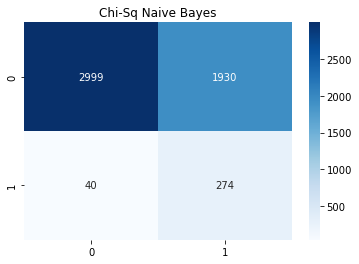

In [150]:
mod = gnb.fit(X_kbest, y_train, sample_weight = weights)
metrics(mod, test_kbest, "Chi-Sq ", mod_name[0])

          Class   TP Rate   FP Rate  Precision    Recall  F-Measure       MCC  \
0      No Fraud  0.958004  0.831210   0.947622  0.958004   0.952785  0.138583   
1   Fraud Found  0.168790  0.041996   0.203846  0.168790   0.184669  0.138583   
2  Weighted Avg  0.910738  0.783945   0.903078  0.910738   0.906783  0.138583   

    ROC-AUC  
0  0.563397  
1  0.563397  
2  0.563397  


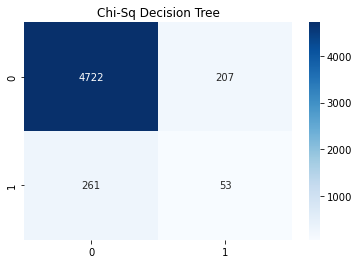

In [151]:
mod = tree.fit(X_kbest, y_train, sample_weight = weights)
metrics(mod, test_kbest, "Chi-Sq ", mod_name[1])

          Class   TP Rate   FP Rate  Precision    Recall  F-Measure       MCC  \
0      No Fraud  0.988233  0.952229   0.942166  0.988233   0.964650  0.072909   
1   Fraud Found  0.047771  0.011767   0.205479  0.047771   0.077519  0.072909   
2  Weighted Avg  0.931909  0.895906   0.898047  0.931909   0.911520  0.072909   

    ROC-AUC  
0  0.556152  
1  0.556152  
2  0.556152  


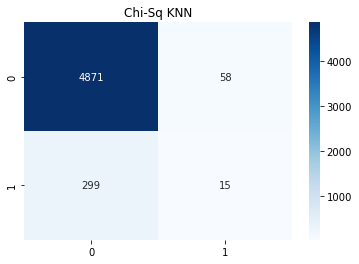

In [152]:
mod = knn.fit(X_kbest, y_train)
metrics(mod, test_kbest, "Chi-Sq ", mod_name[2])

          Class   TP Rate   FP Rate  Precision    Recall  F-Measure       MCC  \
0      No Fraud  0.637046  0.140127   0.986181  0.637046   0.774066  0.241443   
1   Fraud Found  0.859873  0.362954   0.131132  0.859873   0.227560  0.241443   
2  Weighted Avg  0.650391  0.153472   0.934973  0.650391   0.741336  0.241443   

    ROC-AUC  
0  0.804498  
1  0.804498  
2  0.804498  


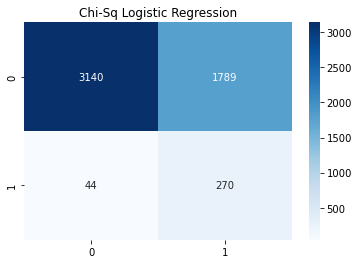

In [153]:
mod = log.fit(X_kbest, y_train, sample_weight = weights)
metrics(mod, test_kbest, "Chi-Sq ", mod_name[3])

          Class   TP Rate   FP Rate  Precision    Recall  F-Measure       MCC  \
0      No Fraud  0.603976  0.105096   0.989037  0.603976   0.749969  0.239394   
1   Fraud Found  0.894904  0.396024   0.125840  0.894904   0.220652  0.239394   
2  Weighted Avg  0.621400  0.122519   0.937340  0.621400   0.718268  0.239394   

    ROC-AUC  
0  0.791575  
1  0.791575  
2  0.791575  


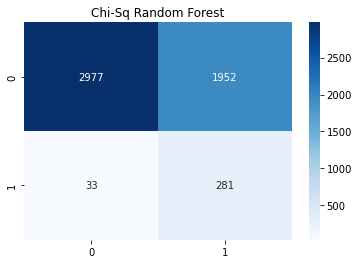

In [154]:
mod = rf.fit(X_kbest, y_train, sample_weight = weights)
metrics(mod, test_kbest, "Chi-Sq ", mod_name[4])

# SelectKBest: Univariate Feature Selection

In [155]:
selector = SelectKBest(f_classif, k=6)
selector.fit(X_train, y_train)
X_kbest = X_train.iloc[:, selector.get_support()]
test_kbest = X_test.iloc[:, selector.get_support()]

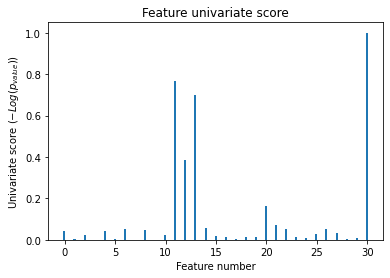

In [156]:
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
X_indices = np.arange(X.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, scores, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()

          Class   TP Rate   FP Rate  Precision    Recall  F-Measure       MCC  \
0      No Fraud  0.606817  0.117834   0.987781  0.606817   0.751791  0.234894   
1   Fraud Found  0.882166  0.393183   0.125056  0.882166   0.219059  0.234894   
2  Weighted Avg  0.623307  0.134325   0.936113  0.623307   0.719886  0.234894   

    ROC-AUC  
0  0.774643  
1  0.774643  
2  0.774643  


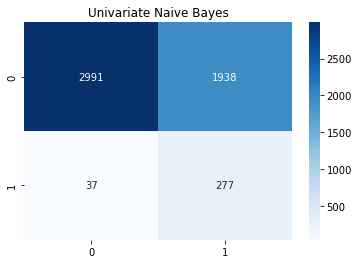

In [157]:
mod = gnb.fit(X_kbest, y_train, sample_weight = weights)
metrics(mod, test_kbest, "Univariate ", mod_name[0])

          Class   TP Rate   FP Rate  Precision    Recall  F-Measure       MCC  \
0      No Fraud  0.637452  0.178344   0.982489  0.637452   0.773225  0.223343   
1   Fraud Found  0.821656  0.362548   0.126161  0.821656   0.218737  0.223343   
2  Weighted Avg  0.648484  0.189376   0.931204  0.648484   0.740017  0.223343   

    ROC-AUC  
0  0.779809  
1  0.779809  
2  0.779809  


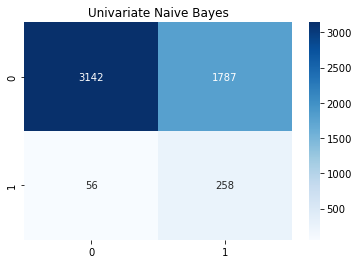

In [158]:
mod = tree.fit(X_kbest, y_train, sample_weight = weights)
metrics(mod, test_kbest, "Univariate ", mod_name[0])

          Class   TP Rate   FP Rate  Precision    Recall  F-Measure       MCC  \
0      No Fraud  0.988842  0.958599   0.941836  0.988842   0.964766  0.063424   
1   Fraud Found  0.041401  0.011158   0.191176  0.041401   0.068063  0.063424   
2  Weighted Avg  0.932100  0.901857   0.896879  0.932100   0.911063  0.063424   

    ROC-AUC  
0  0.589327  
1  0.589327  
2  0.589327  


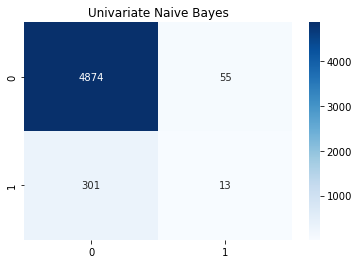

In [159]:
mod = knn.fit(X_kbest, y_train)
metrics(mod, test_kbest, "Univariate ", mod_name[0])

          Class   TP Rate   FP Rate  Precision    Recall  F-Measure       MCC  \
0      No Fraud  0.607223  0.121019   0.987463  0.607223   0.752010  0.233602   
1   Fraud Found  0.878981  0.392777   0.124774  0.878981   0.218527  0.233602   
2  Weighted Avg  0.623498  0.137295   0.935797  0.623498   0.720060  0.233602   

    ROC-AUC  
0  0.791228  
1  0.791228  
2  0.791228  


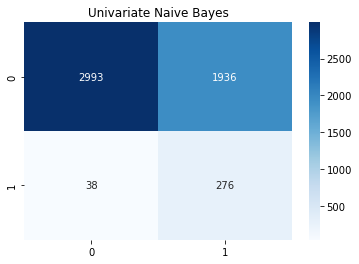

In [160]:
mod = log.fit(X_kbest, y_train, sample_weight = weights)
metrics(mod, test_kbest, "Univariate ", mod_name[0])

          Class   TP Rate   FP Rate  Precision    Recall  F-Measure       MCC  \
0      No Fraud  0.596876  0.076433   0.991908  0.596876   0.745282  0.249144   
1   Fraud Found  0.923567  0.403124   0.127361  0.923567   0.223852  0.249144   
2  Weighted Avg  0.616441  0.095998   0.940131  0.616441   0.714054  0.249144   

    ROC-AUC  
0  0.794974  
1  0.794974  
2  0.794974  


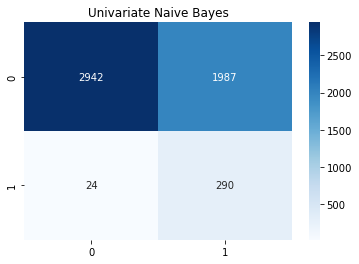

In [161]:
mod = rf.fit(X_kbest, y_train, sample_weight = weights)
metrics(mod, test_kbest, "Univariate ", mod_name[0])

# Sequential Feature Selector

In [162]:
from sklearn.feature_selection import SequentialFeatureSelector
models = [gnb, tree, knn, log, rf]
for i in range(len(models)):
    sfs = SequentialFeatureSelector(models[i], n_features_to_select=10)
    sfs.fit(X_train, y_train)
    if(i == 0):
        gnb_train = X_train.iloc[:, sfs.get_support()]
        gnb_test = X_test.iloc[:, sfs.get_support()]
    elif(i ==1):
        tree_train = X_train.iloc[:, sfs.get_support()]
        tree_test = X_test.iloc[:, sfs.get_support()]
    elif(i ==2):
        knn_train = X_train.iloc[:, sfs.get_support()]
        knn_test = X_test.iloc[:, sfs.get_support()]
    elif(i ==3):
        log_train = X_train.iloc[:, sfs.get_support()]
        log_test = X_test.iloc[:, sfs.get_support()]
    else:
        rf_train = X_train.iloc[:, sfs.get_support()]
        rf_test = X_test.iloc[:, sfs.get_support()]

          Class   TP Rate   FP Rate  Precision    Recall  F-Measure       MCC  \
0      No Fraud  0.480422  0.388535   0.951004  0.480422   0.638361  0.043661   
1   Fraud Found  0.611465  0.519578   0.069742  0.611465   0.125204  0.043661   
2  Weighted Avg  0.488270  0.396383   0.898226  0.488270   0.607628  0.043661   

    ROC-AUC  
0  0.567198  
1  0.567198  
2  0.567198  


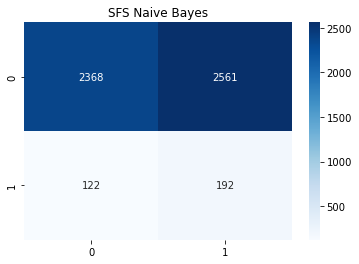

In [163]:
mod = gnb.fit(gnb_train, y_train, sample_weight = weights)
metrics(mod, gnb_test, "SFS ", mod_name[0])

          Class   TP Rate   FP Rate  Precision    Recall  F-Measure       MCC  \
0      No Fraud  0.689186  0.187898   0.982928  0.689186   0.810256  0.250947   
1   Fraud Found  0.812102  0.310814   0.142697  0.812102   0.242742  0.250947   
2  Weighted Avg  0.696548  0.195259   0.932607  0.696548   0.776268  0.250947   

    ROC-AUC  
0  0.795232  
1  0.795232  
2  0.795232  


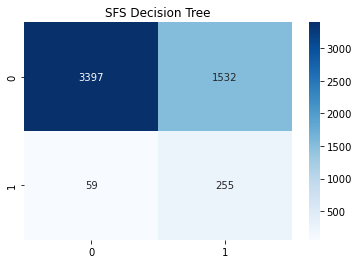

In [164]:
mod = tree.fit(tree_train, y_train, sample_weight = weights)
metrics(mod, tree_test, "SFS ", mod_name[1])

          Class   TP Rate   FP Rate  Precision    Recall  F-Measure       MCC  \
0      No Fraud  0.989856  0.974522   0.940984  0.989856   0.964801  0.034786   
1   Fraud Found  0.025478  0.010144   0.137931  0.025478   0.043011  0.034786   
2  Weighted Avg  0.932100  0.916766   0.892889  0.932100   0.909596  0.034786   

    ROC-AUC  
0  0.528764  
1  0.528764  
2  0.528764  


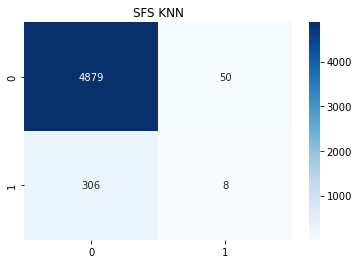

In [165]:
mod = knn.fit(knn_train, y_train)
metrics(mod, knn_test, "SFS ", mod_name[2])

          Class   TP Rate   FP Rate  Precision    Recall  F-Measure       MCC  \
0      No Fraud  0.536823  0.455414   0.948727  0.536823   0.685670  0.038713   
1   Fraud Found  0.544586  0.463177   0.069682  0.544586   0.123555  0.038713   
2  Weighted Avg  0.537288  0.455879   0.896082  0.537288   0.652005  0.038713   

    ROC-AUC  
0  0.568162  
1  0.568162  
2  0.568162  


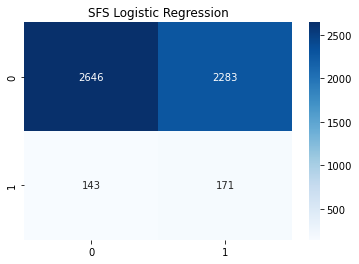

In [166]:
mod = log.fit(log_train, y_train, sample_weight = weights)
metrics(mod, log_test, "SFS ", mod_name[3])

          Class   TP Rate   FP Rate  Precision    Recall  F-Measure       MCC  \
0      No Fraud  0.425644  0.343949   0.951043  0.425644   0.588087  0.039266   
1   Fraud Found  0.656051  0.574356   0.067830  0.656051   0.122948  0.039266   
2  Weighted Avg  0.439443  0.357748   0.898148  0.439443   0.560230  0.039266   

    ROC-AUC  
0  0.566527  
1  0.566527  
2  0.566527  


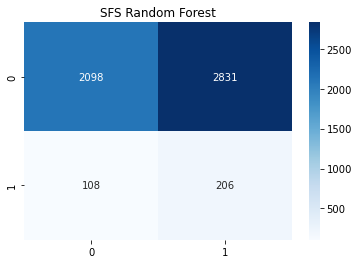

In [167]:
mod = rf.fit(rf_train, y_train, sample_weight = weights)
metrics(mod, rf_test, "SFS ", mod_name[4])